In [1]:
## librerías
import os
import torch
import os

gpu="0"

if gpu:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu #aca se pone nuemro de grafica libre

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using GPU: {torch.cuda.get_device_name()}')
    print('CUDA Visible devices:',os.getenv('CUDA_VISIBLE_DEVICES'))
else:
    device = torch.device('cpu')
    print("Failed to find GPU, using CPU instead.")
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 
import glob

## Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

#### Modelo
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import networkx as nx

Using GPU: NVIDIA GeForce RTX 3080
CUDA Visible devices: 0


# Dataset

In [2]:
## Function to get contours and features
def get_contours_and_features(binary_map):
    #https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html
    #binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_features = []
    for contour in contours:
        error = 1e-5
        moments = cv2.moments(contour)
        cx = moments['m10'] / (moments['m00'] + error)
        cy = moments['m01'] / (moments['m00'] + error)
        center_of_mass = [cx, cy]
        x,y,w,h = cv2.boundingRect(contour)        
        rect_area = w*h
        features = {
            'bounding_box': (x,y,w,h),
            'area': cv2.contourArea(contour),
            'perimeter': cv2.arcLength(contour, True),
            'aspect_ratio': np.float32(w)/h, 
            'extent': np.float32(cv2.contourArea(contour))/rect_area,
            #'solidity': np.float32(cv2.contourArea(contour))/cv2.convexHull(contour),
            'equivalent_diameter': np.sqrt(cv2.contourArea(contour)/np.pi),            
            'moments': moments,
            'center_of_mass': center_of_mass,
            'contour': contour
        }
        contours_features.append(features)
        del features
    #plt.imshow(contours_map, cmap='gray')
    return contours_features


# function to get a determined property from a list of contours features (area by default)
def get_item(contour_features, key='area'):
    areas = []
    for contour_feature in contour_features:
        area =  contour_feature[key]
        areas.append(area)
    return areas

# function to get tensor of one image
def load_image(file_name):
    raw = cv2.imread(file_name)
    raw = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
    raw = cv2.resize(raw, (128, 128))
    raw = raw/255.0
    return raw

# function to get set of binary image from image loaded
def get_binary_image(filenames):
    tensores = []
    for filename in filenames:
        raw = cv2.imread(filename)
        raw = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        raw = cv2.resize(raw, (128, 128))
        raw = raw/255.0
        raw = raw.astype(np.uint8)
        tensores.append(raw)
    return tensores

def get_geometric_atributes(binary_images):
    descriptors = []
    for binary_img in binary_images:
        ## Formato
        image = binary_img    
        
        ## Capturar contornos
        contour_features = get_contours_and_features(image)
        
        ## Calcular vector de áreas de poro (todos los poros)
        areas = get_item(contour_features, key='area')

        ## Calcular vector de perímetros de poro (todo los poros)
        pmtro = get_item(contour_features, key='perimeter')

        ## Calcular el diametro equivalente de los poros
        eq_diameter = get_item(contour_features, key='equivalent_diameter')
        
        ## Calcular el aspect ratio de los poros
        aspect_ratio = get_item(contour_features, key='aspect_ratio')

        ## Número de poros
        npores = np.shape(areas)[0]

        descriptor = [np.mean(areas), np.mean(pmtro), np.mean(eq_diameter), np.mean(aspect_ratio), npores]
        
        descriptors.append(descriptor)       
    
    return descriptors

## Reorganizar atributos geométricos
def organize_geometric_atributes(dataset):
    attributes = []
    for i in range(len(dataset)):
        attributes.append([dataset['area'].to_numpy()[i],dataset['perimetro'].to_numpy()[i],dataset['intersticio'].to_numpy()[i],dataset['poros'].to_numpy()[i]])

    return attributes

def get_pores_features(mask):    
    ## Calcular atributos geométricos
    atrs = get_contours_and_features(mask)
    ## lista con los poros
    pores = []
    for pore in atrs:
        ## centro de masa del poro
        cx = pore['center_of_mass'][0]
        cy = pore['center_of_mass'][1]
        ## area del poro
        area = pore['area']
        ## perimetro del poro
        perimeter = pore['perimeter']
        ## diametro equivalente del poro
        eq_diameter = pore['equivalent_diameter']

        pores.append([cx,cy,area,perimeter,eq_diameter])
        
    ## convertir a dataframe
    pores_df = pd.DataFrame(pores,columns=['cx','cy','area','perimeter','eq_diameter'])
    
    ## drop filas con valores nulos y areas iguals a cero
    pores_df = pores_df.dropna()
    pores_df = pores_df[pores_df['area'] != 0]

    ## drop filas con valores nulos y areas iguals a cero
    pores_df = pores_df.dropna()
    pores_df = pores_df[pores_df['area'] != 0]


    ## extraer la localización de los poros en dataframe aparte
    pores_location = pores_df[['cx','cy']]

    ## extraer features a parte
    pores_features = pores_df[['area','perimeter','eq_diameter']]


    return pores_features, pores_location

def get_routes_dataset(rutas_dataset):
    ## Separar rutas
    mask_list = []
    image_list = []
    for ruta in rutas_dataset:    
        ruta_list = ruta.split('/')       
        clase = ruta_list[6]
        number = ruta_list[7]
        tipo = ruta_list[8]
        name = ruta_list[9].split('.')[0]
        
        if tipo == 'train':
            image_list.append([name,ruta,clase,number])
        elif tipo == 'mask_bin':
            mask_list.append([name,ruta,clase,number])
        else:
            None

    mask_pd = pd.DataFrame(mask_list,columns=['name','route_mask','label','number']).sort_values(by='name')
    image_pd = pd.DataFrame(image_list,columns=['name','route_image','label','number']).sort_values(by='name')

    routes_dataset = image_pd.merge(mask_pd,on=['name','label','number'],how='left')

    routes_dataset.dropna(inplace=True)

    routes_dataset = routes_dataset.sample(frac = 1)

    return routes_dataset

def split_dataset(routes_dataset):
    ## Establecer el porcentaje de separación
    thold1 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label==0])))
    thold2 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label==1])))
    thold3 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label==2])))

    ## Separar por clases para entrenamiento
    train_cu1 = routes_dataset[routes_dataset.label == 0][0:thold1]
    train_cu2 = routes_dataset[routes_dataset.label == 1][0:thold2]
    train_cu3 = routes_dataset[routes_dataset.label == 2][0:thold3]

    ## tomar las demás imágenes para test
    test_cu1 = routes_dataset[routes_dataset.label == 0][thold1:]
    test_cu2 = routes_dataset[routes_dataset.label == 1][thold2:]
    test_cu3 = routes_dataset[routes_dataset.label == 2][thold3:]


    ## Constuir un solo dataset de training
    train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3]).sample(frac=1,random_state=42).reset_index(drop=True)

    ## Construir un solo dataset de test
    test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3]).sample(frac=1,random_state=100).reset_index(drop=True)

    ## Cantidad de muestras por clase
    print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
    print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
    print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

    return train_df, test_df

def image_to_grapph(mask_route,max_diff = 0.2):
    ## cargar máscara
    mask = get_binary_image([mask_route])[0]    

    ## cargar features from mask
    pores_features, pores_location = get_pores_features(mask)

    ## Definir nodos de un grafo usando pytorch geometric
    from torch_geometric.data import Data

    ## definir nodos
    nodes = torch.tensor(pores_features.to_numpy(),dtype=torch.float)

    ## definir aristas a partir de similitud entre nodos
    edges = []

    for i in range(len(nodes)):
        for j in range(i+1,len(nodes)):
            ## diferencia
            diff = torch.mean(torch.abs(nodes[i] - nodes[j])/torch.abs(nodes[i] + nodes[j]))
            ## añadir arista si la diferencia es menor a 0.2
            if diff < max_diff:
                edges.append([i,j])
            
    edges = torch.tensor(edges).t().contiguous()

    ## definir grafo
    data = Data(x=nodes, edge_index=edges)
    
    return data

def get_routes_dataset_regression(rutas_dataset):
    ## Separar rutas
    ## /home/Data/Datasets/Micrografías macroproperties/Segmentaciones/MF1/1/Mask/20221026_115804_jpg.rf.552cf2129947708f34806dca73441f72.jpg
    mask_list = []
    image_list = []
    electro_active_area = []
    retained_mass = []
    electro_deposed_mass = []
    
    for ruta in rutas_dataset:    
        ruta_list = ruta.split('/')       
        clase = ruta_list[6]
        number = ruta_list[7]
        tipo = ruta_list[8]
        name = ruta_list[9].split('.jpg')[0]      
        
            
        if clase == 'MF1':
            if number == '1':
                electro_deposed_mass = 16.85
                electro_active_area = 674.15
                retained_mass = 91.09                
            elif number == '2':
                electro_deposed_mass = 16.92
                electro_active_area = 650.12
                retained_mass = 90.54     
            elif number == '3':
                electro_deposed_mass = 16.78
                electro_active_area = 646.78
                retained_mass = 91.06     
            elif number == '4':
                electro_deposed_mass = 16.78
                electro_active_area = 662.33
                retained_mass = 90.46     
            else:
                None
        #------------------------------------------------------
        elif clase == 'MF2':
            if number == '1':
                electro_deposed_mass = 12.55
                electro_active_area = 941.7
                retained_mass = 94.42     
            elif number == '2':
                electro_deposed_mass = 12.65
                electro_active_area = 912.6
                retained_mass = 93.67
            elif number == '3':
                electro_deposed_mass = 12.60
                electro_active_area = 915.24
                retained_mass = 93.65
            elif number == '4':
                electro_deposed_mass = 12.58
                electro_active_area = 925.4    
                retained_mass = 93.64     
            else:
                None
        # -------------------------------------------------------  
        elif clase == 'MF3':
            if number == '1':
                electro_deposed_mass = 8.09
                electro_active_area = 1225.2
                retained_mass = 98.76
            elif number == '2':
                electro_deposed_mass = 8.10
                electro_active_area = 1242.2
                retained_mass = 98.76
            elif number == '3':
                electro_deposed_mass = 8.11
                electro_active_area = 1214.5
                retained_mass = 97.53
            elif number == '4':
                electro_deposed_mass = 8.10
                electro_active_area = 1220.3
                retained_mass = 98.76
            else:
                None

                
                
        if tipo == 'train':
            image_list.append([name,ruta,clase,number,electro_deposed_mass,electro_active_area,retained_mass])
        elif tipo == 'Mask':
            mask_list.append([name,ruta,clase,number,electro_deposed_mass,electro_active_area,retained_mass])
        else:
            None

    mask_pd = pd.DataFrame(mask_list,
                           columns=['name','route_mask','label','number','mass_electrodeposited','area_electroactive','retained_mass']).sort_values(by='name')
    image_pd = pd.DataFrame(image_list,
                            columns=['name','route_image','label','number','mass_electrodeposited','area_electroactive','retained_mass']).sort_values(by='name')

    routes_dataset = image_pd.merge(mask_pd,on=['name','label','number','mass_electrodeposited','area_electroactive','retained_mass'],how='left')

    routes_dataset.dropna(inplace=True)

    routes_dataset = routes_dataset.sample(frac = 1)

    return routes_dataset

In [3]:
## Obtener todas las rutas de las imágenes en el dataset
## ejemplo de estructura de ruta: /home/Data/Datasets/Micrografías macroproperties/Segmentaciones/MF1/1/Mask/20221026_115804_jpg.rf.552cf2129947708f34806dca73441f72.jpg
rutas_dataset  = glob.glob('../../../Datasets/Micrografías_macroproperties/Segmentaciones/*/*/*/*.jpg')

routes_dataset = get_routes_dataset_regression(rutas_dataset)

## replace label names for numbers
pd.set_option('future.no_silent_downcasting', True)
routes_dataset['label'] = routes_dataset['label'].replace(['MF1','MF2','MF3'],[0,1,2])

routes_dataset

,name,route_image,label,number,mass_electrodeposited,area_electroactive,retained_mass,route_mask
354,IMG_20230711_163455_jpg.rf.f5e550484a76d50ff54...,../../../Datasets/Micrografías_macroproperties...,1,3,12.60,915.24,93.65,../../../Datasets/Micrografías_macroproperties...
438,IMG_20230711_185450_jpg.rf.e359c12396c930df587...,../../../Datasets/Micrografías_macroproperties...,1,4,12.58,925.40,93.64,../../../Datasets/Micrografías_macroproperties...
113,20221028_122410_jpg.rf.a27f6cedba52d61eb51d00f...,../../../Datasets/Micrografías_macroproperties...,2,1,8.09,1225.20,98.76,../../../Datasets/Micrografías_macroproperties...
30,20221026_134456_jpg.rf.c8b31f711b56a77a4c78564...,../../../Datasets/Micrografías_macroproperties...,0,1,16.85,674.15,91.09,../../../Datasets/Micrografías_macroproperties...
322,IMG_20230707_185041_jpg.rf.e8f8133b0e6e9665b55...,../../../Datasets/Micrografías_macroproperties...,0,3,16.78,646.78,91.06,../../../Datasets/Micrografías_macroproperties...
...,...,...,...,...,...,...,...,...
442,IMG_20230711_185524_jpg.rf.ee302ffcc616570bb50...,../../../Datasets/Micrografías_macroproperties...,1,4,12.58,925.40,93.64,../../../Datasets/Micrografías_macroproperties...
399,IMG_20230711_174546_jpg.rf.4f4f852c21b774454a9...,../../../Datasets/Micrografías_macroproperties...,1,2,12.65,912.60,93.67,../../../Datasets/Micrografías_macroproperties...
342,IMG_20230711_163316_jpg.rf.3a5729e66f8f8617291...,../../../Datasets/Micrografías_macroproperties...,1,3,12.60,915.24,93.65,../../../Datasets/Micrografías_macroproperties...
394,IMG_20230711_174511_jpg.rf.b796f79ccd89d538790...,../../../Datasets/Micrografías_macroproperties...,1,2,12.65,912.60,93.67,../../../Datasets/Micrografías_macroproperties...


In [4]:
mask_route = routes_dataset['route_mask'].to_numpy()[0]

## Constuir una matriz de atributos geométricos de la imagen
mask = get_binary_image([mask_route])[0]

pores_features, pores_location = get_pores_features(mask)

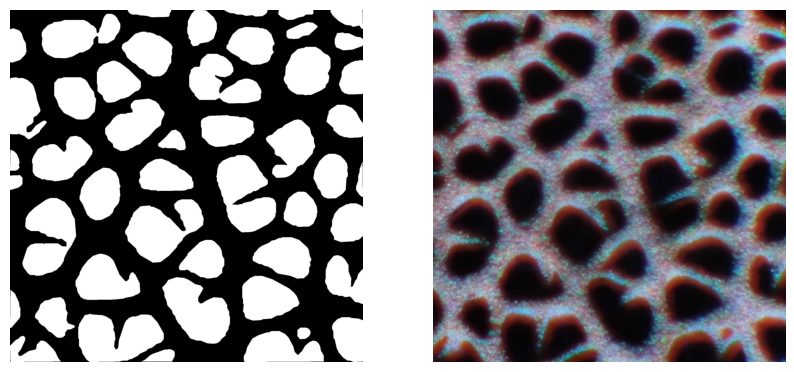

<Figure size 640x480 with 0 Axes>

In [5]:
## seleccionar una imagen aleatoria
idx = 0
mask_route = routes_dataset['route_mask'].to_numpy()[idx]
image_route = routes_dataset['route_image'].to_numpy()[idx]

## plot mascara y original
mask = cv2.imread(mask_route)
image = cv2.imread(image_route)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(mask)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(image)
plt.axis('off')
plt.show()
plt.tight_layout()

### Crear DataLoader

In [6]:
class MFsImagesDataset(Dataset):
    def __init__(self, routes_dataframe):
        self.routes_dataframe = routes_dataframe
        self.image_paths = []
        self.mask_paths = []
        self.labels = []
        self.electro_deposed_mass = []
        self.electro_active_area = []
        self.retained_mass = []
        self.graphs = []
        self.transform_mask = transforms.Compose([
            transforms.Grayscale(),  # Ensure the image is grayscale
            transforms.Resize((128, 128)),  # Resize to 128x128
            transforms.ToTensor()
        ])
        self.transform_image = transforms.Compose([
            transforms.Resize((128, 128)),  # Resize to 128x128
            transforms.ToTensor()
        ])       
        
        # Recursively gather all image paths in the folder and subfolders
        for idx in range(len(self.routes_dataframe)):
            mask_route = self.routes_dataframe['route_mask'].to_numpy()[idx]
            image_route = self.routes_dataframe['route_image'].to_numpy()[idx]
            clase = torch.tensor(self.routes_dataframe['label'].to_numpy()[idx])
            electro_deposed_mass = torch.tensor(self.routes_dataframe['mass_electrodeposited'].to_numpy()[idx])
            electro_active_area = torch.tensor(self.routes_dataframe['area_electroactive'].to_numpy()[idx])
            retained_mass = torch.tensor(self.routes_dataframe['retained_mass'].to_numpy()[idx])
            
            self.image_paths.append(image_route)
            self.mask_paths.append(mask_route)
            self.labels.append(clase)
            self.electro_deposed_mass.append(electro_deposed_mass)
            self.electro_active_area.append(electro_active_area)
            self.retained_mass.append(retained_mass)
                          
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        ## leer imagen, más y etiqueta
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image_label = self.labels[idx]
        image_electro_deposed_mass = self.electro_deposed_mass[idx]
        image_electro_active_area = self.electro_active_area[idx]
        image_retained_mass = self.retained_mass[idx]
        
        ## cargar imagen y máscara y aplicar transformaciones
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        image = self.transform_image(image)
        mask = self.transform_mask(mask)
        ## obtener propiedades de los poros de la máscara
        graph = image_to_grapph(mask_path,max_diff = 0.2)
        
                    
        return image, mask, graph, image_label, image_electro_deposed_mass, image_electro_active_area, image_retained_mass

def collate_fn(batch):
    import torch_geometric
    images, masks, graphs, labels, image_electro_deposed_mass, image_electro_active_area, image_retained_mass = zip(*batch)
    
    # Convert lists to tensors if necessary
    images = torch.stack(images)
    masks = torch.stack(masks)
    labels = torch.tensor(labels)
    image_electro_deposed_mass = torch.tensor(image_electro_deposed_mass)
    image_electro_active_area = torch.tensor(image_electro_active_area)
    image_retained_mass = torch.tensor(image_retained_mass)
    
    # Batch the graphs using torch_geometric's batch function
    graphs = torch_geometric.data.Batch.from_data_list(graphs)
    
    return images, masks, graphs, labels, image_electro_deposed_mass, image_electro_active_area, image_retained_mass
    
## split dataset into train and test 80-20
train_df, test_df = split_dataset(routes_dataset)

train_dataset = MFsImagesDataset(train_df)
test_dataset = MFsImagesDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

Clase MF1: train:  123 , test:  30
Clase MF2: train:  133 , test:  33
Clase MF3: train:  112 , test:  27


In [7]:
for image, mask, graph, label, edm, eaa, rm in train_loader:
    print('Image shape:', image.shape)
    print('Mask shape:', mask.shape)
    print('label')
    print('Graph information:')
    print('Number of nodes:', graph.num_nodes)
    print('Number of edges:', graph.num_edges)
    print('Number of features:', graph.num_features)
    print('Number of edge features:', graph.num_edge_features)
    print('Number of node features:', graph.num_node_features)
    break

Image shape: torch.Size([1, 3, 128, 128])
Mask shape: torch.Size([1, 1, 128, 128])
label
Graph information:
Number of nodes: 37
Number of edges: 209
Number of features: 3
Number of edge features: 0
Number of node features: 3


# Modelo

In [8]:
## Graph convoluitonal network for classification

import torch
from torch import Tensor
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.edm = nn.Linear(out_channels, 1)
        self.eaa = nn.Linear(out_channels, 1)
        self.rm = nn.Linear(out_channels, 1)
        
        

    def forward(self, x, edge_index):
        #print(f'Input x shape: {x.shape}')
        #print(f'Input edge_index shape: {edge_index.shape}')
        
        x = self.conv1(x, edge_index).relu()
        #print(f'After conv1 x shape: {x.shape}')
        ## Function to get contours and features

        x = self.conv2(x, edge_index).relu()
        #print(f'After conv2 x shape: {x.shape}')
                
        x = self.conv3(x, edge_index).relu()
        #print(f'After conv3 x shape: {x.shape}')
        
        x = torch.mean(x, dim=0)  # Example: mean pooling
        #print(f'After pooling x shape: {x.shape}')
        
        edm = self.edm(x)
        
        eaa = self.eaa(x)
        
        rm = self.rm(x)      
        
        return edm, eaa, rm



In [9]:
# Initialize the model
model = GCN(in_channels=3, hidden_channels=64, out_channels=64, num_classes=3)

for param in model.parameters():
    param.requires_grad = True   
    
optimizer = optim.Adam(model.parameters(), lr=0.01)

model.load_state_dict(torch.load('Models/model_gnn_regression_2.pth'))

<All keys matched successfully>

## Metrics evaluation for regression model

In [10]:
preds = []
labels = []

model.eval()

for image, mask, graph, label, edm, eaa, rm in test_loader:    
    pred_edm, pred_eaa, pred_rm = model(graph.x, graph.edge_index)
    preds.append([pred_edm.item(), pred_eaa.item(), pred_rm.item()])
    labels.append([edm.item(), eaa.item(), rm.item()])
    
preds = np.array(preds)
labels = np.array(labels)

## Calcular errores absolutos
errors = np.abs(preds - labels)

# error absoluto por cada propiedad
errors_edm = errors[:,0]
errors_eaa = errors[:,1]
errors_rm = errors[:,2]

## calcular errores relativos
rel_errors = np.abs((preds - labels)/labels)

# error relativo por cada propiedad
rel_errors_edm = rel_errors[:,0]
rel_errors_eaa = rel_errors[:,1]
rel_errors_rm = rel_errors[:,2]

## calcular errores absolutos medios
mae_edm = np.mean(errors_edm)
mae_eaa = np.mean(errors_eaa)
mae_rm = np.mean(errors_rm)

## calcular errores relativos medios
mre_edm = np.mean(rel_errors_edm)
mre_eaa = np.mean(rel_errors_eaa)
mre_rm = np.mean(rel_errors_rm)

print('Mean Absolute Error (MAE) for Electrodeposited Mass:', mae_edm)
print('Mean Absolute Error (MAE) for Electroactive Area:', mae_eaa)
print('Mean Absolute Error (MAE) for Retained Mass:', mae_rm)

print('Mean Relative Error (MRE) for Electrodeposited Mass:', mre_edm)
print('Mean Relative Error (MRE) for Electroactive Area:', mre_eaa)
print('Mean Relative Error (MRE) for Retained Mass:', mre_rm)

Mean Absolute Error (MAE) for Electrodeposited Mass: 2.20892056910197
Mean Absolute Error (MAE) for Electroactive Area: 111.61701681857639
Mean Absolute Error (MAE) for Retained Mass: 2.945858194986978
Mean Relative Error (MRE) for Electrodeposited Mass: 0.1507815266690261
Mean Relative Error (MRE) for Electroactive Area: 0.12300632762358943
Mean Relative Error (MRE) for Retained Mass: 0.031122962782857613


In [11]:
## dataframe que resume los datos
data = {'MAE':[mae_edm,mae_eaa,mae_rm],
        'MRE':[mre_edm,mre_eaa,mre_rm]}

df = pd.DataFrame(data,index=['Electrodeposited Mass','Electroactive Area','Retained Mass'])

df

,MAE,MRE
Electrodeposited Mass,2.208921,0.150782
Electroactive Area,111.617017,0.123006
Retained Mass,2.945858,0.031123


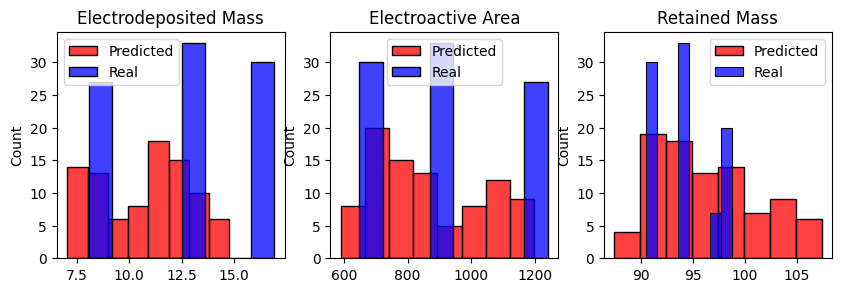

<Figure size 640x480 with 0 Axes>

In [17]:
## comparar valores predichos vs valores reales
plt.figure(figsize=(10,10))
plt.subplot(3,3,1)
#distribuciones a parte
sns.histplot(preds[:,0],color='red',label='Predicted')
sns.histplot(labels[:,0],color='blue',label='Real')
plt.title('Electrodeposited Mass')
plt.legend()
plt.subplot(3,3,2)
#distribuciones a parte
sns.histplot(preds[:,1],color='red',label='Predicted')
sns.histplot(labels[:,1],color='blue',label='Real')
plt.title('Electroactive Area')
plt.legend()
plt.subplot(3,3,3)
#distribuciones a parte
sns.histplot(preds[:,2],color='red',label='Predicted')
sns.histplot(labels[:,2],color='blue',label='Real')
plt.title('Retained Mass')
plt.legend()
plt.show()
plt.tight_layout()